In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageDraw

In [4]:
#load MNIST data
dim_hor = 28
dim_ver = 28
dim = dim_hor * dim_ver
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train / 255).astype(np.float32)
x_test = (x_test / 255).astype(np.float32)
x_train = x_train.reshape([-1, dim])
x_test = x_test.reshape([-1, dim])
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [5]:
#helper to show arrays of images
def imshow(img, draw=True):
    img = img.reshape([-1, 28, 28])
    out = np.empty([0, 280])
    for row in range((len(img) - 1) // 10 + 1):
        add = np.hstack(img[row * 10: row * 10 + 10])
        add = np.hstack([add, np.zeros([28, 280 - add.shape[1]])])
        out = np.vstack([out, add])
    if draw:
        fig = plt.figure(figsize=(20, 15))
        plt.imshow(out)
    else:
        return out

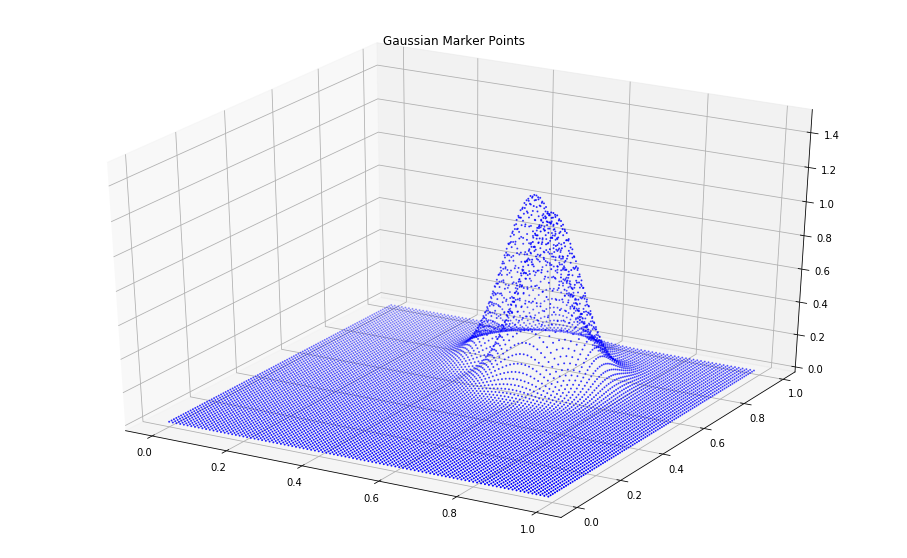

In [6]:
#visualizing gaussian marker points
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Gaussian Marker Points')
x, y = np.meshgrid(np.arange(0, 1, .01), np.arange(0, 1, .01))
ax.set_zlim((0, 1.5))
ax.scatter(x, y, np.maximum(
    np.exp((np.square(x - 0.5) + np.square(y - 0.8)) * -100),
    np.exp((np.square(x - 0.6) + np.square(y - 0.7)) * -100)    
), s=1, c='blue')
plt.show()

In [14]:
#model
tf.reset_default_graph()
sess = tf.InteractiveSession()

points = 10 #number of points to fit the image in
varcoef = 0.01 #coefficient of the point size
epsilon = 0.0001 #fixing dividing by zero

X = tf.placeholder(tf.float32, [None, dim]) #input
Y_ = X #autoregression labels
L = X

#two layers of fully connected NN
L = tf.layers.Dense(units=300, activation=tf.nn.sigmoid)(L)
L = tf.layers.Dense(units=200, activation=tf.nn.sigmoid)(L)
#three output nodes (hor, ver and size) as logits to use with possibly different activations
LOGITS = tf.layers.Dense(units=points * 3, activation=None)(L)

#reshape and activations
LOGITS_ver, LOGITS_hor, LOGITS_size = tf.split(tf.reshape(LOGITS, [-1, points, 3]), 3, axis=2)
POS_ver = tf.nn.sigmoid(LOGITS_ver)
POS_hor = tf.nn.sigmoid(LOGITS_hor)
POS_size = tf.nn.sigmoid(LOGITS_size)

#constant grid with gradients over coordinates
GRAD_ver = tf.tile(tf.expand_dims(tf.range(0., 1., 1. / dim_ver), axis=1), [1, dim_hor])
GRAD_hor = tf.tile(tf.expand_dims(tf.range(0., 1., 1. / dim_hor), axis=0), [dim_ver, 1])
#broadcasted marker point centers (gaussian means)
MEAN_ver = tf.tile(tf.expand_dims(POS_ver, axis=-1), [1, 1, dim_ver, dim_hor])
MEAN_hor = tf.tile(tf.expand_dims(POS_hor, axis=-1), [1, 1, dim_ver, dim_hor])
#broadcasted marker point size (gaussian variation)
VAR2 = tf.tile(tf.expand_dims(POS_size * varcoef + epsilon, axis=-1), [1, 1, dim_ver, dim_hor])
#gaussian marker points vector
MARKER = tf.exp((tf.square(GRAD_hor - MEAN_hor) + tf.square(GRAD_ver - MEAN_ver)) / -VAR2)

#head of the model - predict, loss, train step
Y = tf.reshape(tf.reduce_max(MARKER, axis=1), [-1, dim])
LOSS = tf.losses.mean_squared_error(Y_, Y)
TRAIN = tf.train.AdamOptimizer().minimize(LOSS)
#we set two points accurate if their absolute error is less than 0.5 
ACC = tf.reduce_mean(tf.cast(tf.less(tf.abs(Y_ - Y), 0.5), tf.float32))

tf.global_variables_initializer().run()
tf.local_variables_initializer().run()

In [16]:
#training
num_epochs = 10
batch_size = 16

#collecting gif images here
img = []
img_exp_count = 0
img_exp_step = 10
for epoch in range(num_epochs):
    loss_sum = 0
    acc_sum = 0
    count = 0
    batch_idx = 0
    while batch_idx <= x_train.shape[0] - batch_size:
        res = sess.run([LOSS, ACC, TRAIN], feed_dict={X:x_train[batch_idx: batch_idx + batch_size]})
        loss_sum += res[0]
        acc_sum += res[1]
        count += 1
        img_exp_count += 1
        batch_idx += batch_size
        #video gif visualization (log in time)
        if int(math.log(img_exp_count) * img_exp_step) != int(math.log(img_exp_count + 1) * img_exp_step):
            print('Step visualized: {}'.format(img_exp_count))
            im = Image.new('L', (dim_hor * 10, dim_ver * 10), color=0)
            im.putdata(255 * np.reshape(imshow(sess.run(Y, feed_dict={X:x_train[:100]}), draw=False), [-1]))
            img.append(im)
    print('Epoch: {}\tLoss: {}\tAccuracy: {}'.format(epoch, loss_sum / count, acc_sum / count))
img[0].save('MNIST-position.gif', format='GIF',append_images=img[1:], save_all=True, duration=100, loop=0)

Step visualized: 1
Step visualized: 2
Step visualized: 3
Step visualized: 4
Step visualized: 5
Step visualized: 6
Step visualized: 7
Step visualized: 8
Step visualized: 9
Step visualized: 11
Step visualized: 12
Step visualized: 13
Step visualized: 14
Step visualized: 16
Step visualized: 18
Step visualized: 20
Step visualized: 22
Step visualized: 24
Step visualized: 27
Step visualized: 29
Step visualized: 33
Step visualized: 36
Step visualized: 40
Step visualized: 44
Step visualized: 49
Step visualized: 54
Step visualized: 60
Step visualized: 66
Step visualized: 73
Step visualized: 81
Step visualized: 90
Step visualized: 99
Step visualized: 109
Step visualized: 121
Step visualized: 134
Step visualized: 148
Step visualized: 164
Step visualized: 181
Step visualized: 200
Step visualized: 221
Step visualized: 244
Step visualized: 270
Step visualized: 298
Step visualized: 330
Step visualized: 365
Step visualized: 403
Step visualized: 445
Step visualized: 492
Step visualized: 544
Step visuali

In [17]:
#test
batch_size = 1024
loss_sum = 0
acc_sum = 0
count = 0
batch_idx = 0
while batch_idx <= x_test.shape[0] - batch_size:
    res = sess.run([LOSS, ACC], feed_dict={X:x_test[batch_idx: batch_idx + batch_size]})
    loss_sum += res[0]
    acc_sum += res[1]
    count += 1
    batch_idx += batch_size
print('Test\tLoss: {}\tAccuracy: {}'.format(loss_sum / count, acc_sum / count))

Test	Loss: 0.025649536194072828	Accuracy: 0.9723189738061693


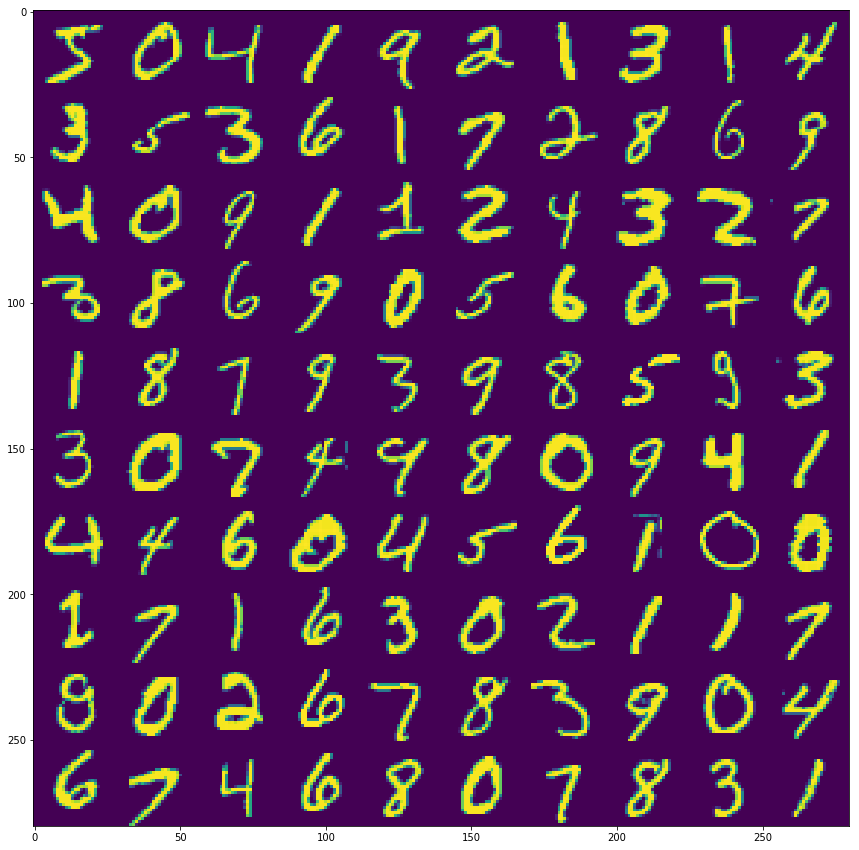

In [20]:
#train input
imshow(x_train[0:100])

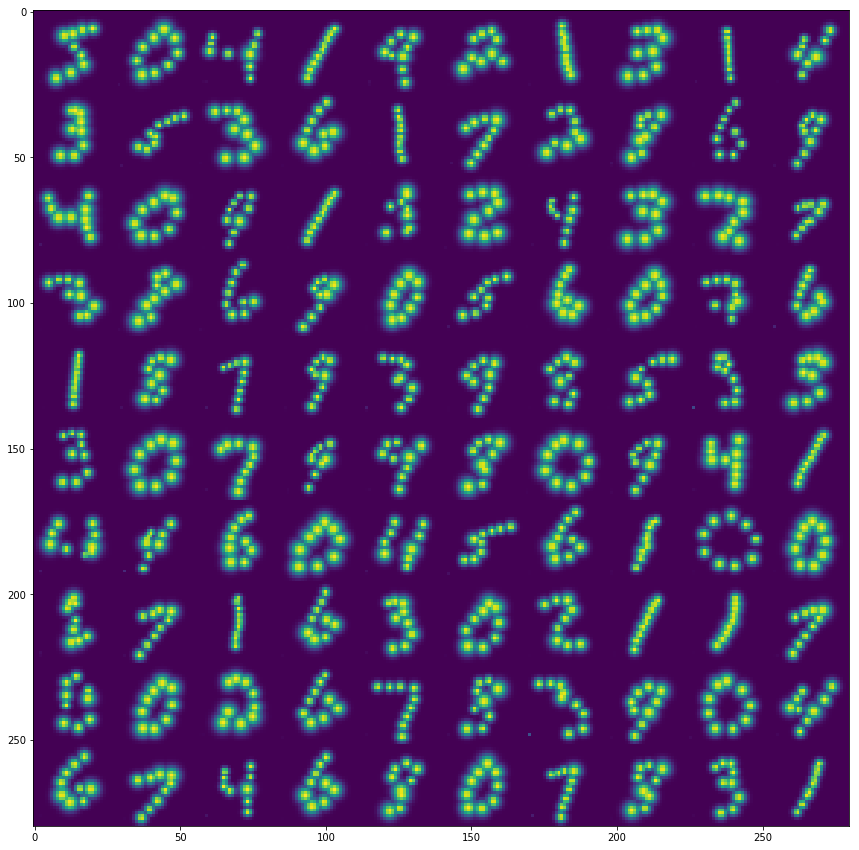

In [21]:
#train output
imshow(sess.run(Y, feed_dict={X:x_train[:100]}))

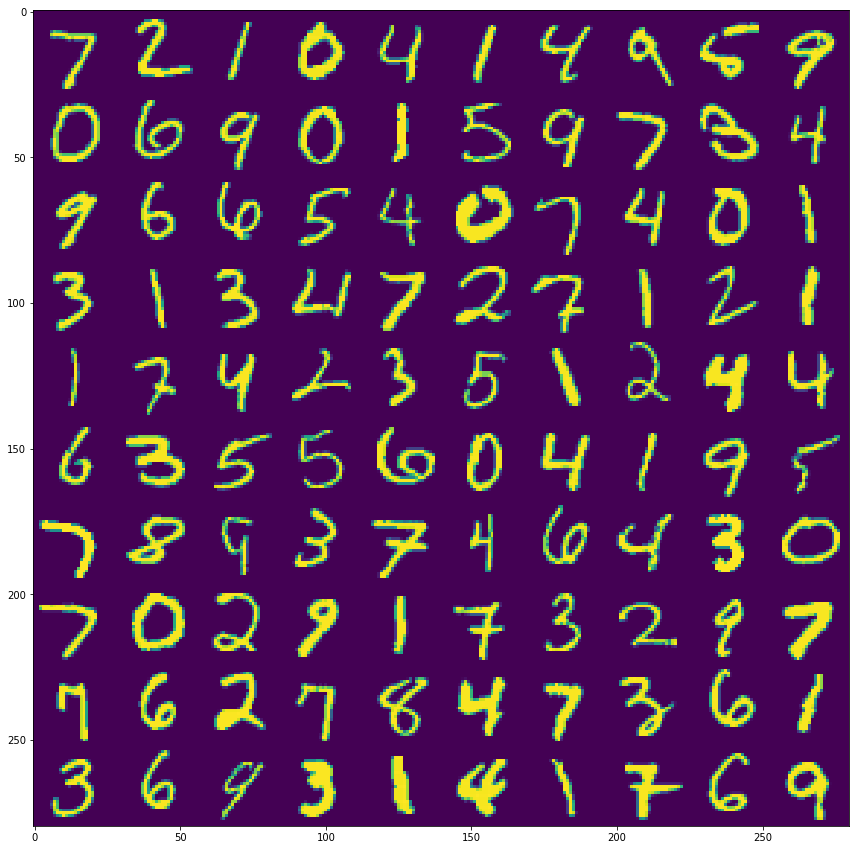

In [22]:
#test input
imshow(x_test[0:100])

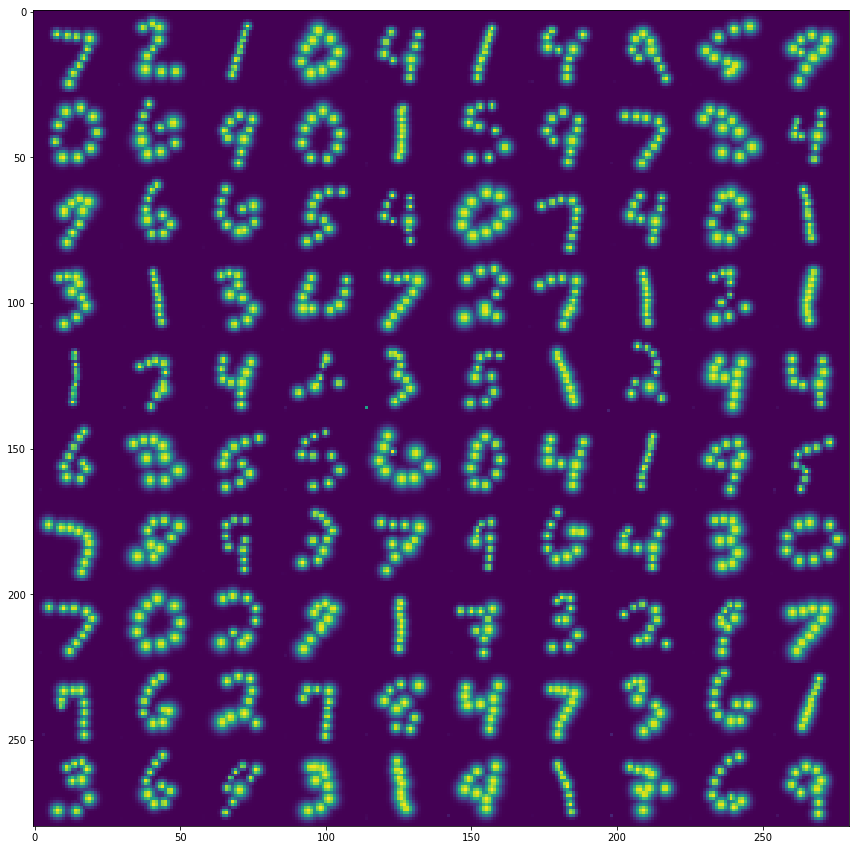

In [23]:
#test output
imshow(sess.run(Y, feed_dict={X:x_test[:100]}))